### They are all equally spaced

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [ ]:
########################################                 Define constants                   #############################################
N = 30
fixed_lam   = 1
k_a = 2 * np.pi / fixed_lam
fixed_gamma = 1

fixed_dist  = 0.235 * fixed_lam
fixed_phi   = np.pi/2

t_max    = 100
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma

In [ ]:
########################################               define the geometry                 #############################################
def phi(t, tau):
    pi_start = np.pi
    pi_end = np.pi / 3
    
    # Define the transition intervals
    t1 = t_max / 10
    t2 = t1 + tau
    
    if t <= t1:
        return pi_start
    elif t >= t2:
        return pi_end
    else:
        # Normalize time to the range [0, pi] for the transition
        normalized_time = ((t - t1) / (t2 - t1)) * np.pi
        
        # Apply sin^2 transition
        sin_squared = np.sin(normalized_time / 2)**2
        
        return pi_start + (pi_end - pi_start) * sin_squared

def dipole_vector(t, tau):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.pi/2 + np.cos(phi(t, tau)), np.pi/2 + np.sin(phi(t, tau)), 0])
    return dipole

def chain_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i,0] = i * distance
    return Pos

positions = chain_positions()

# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
#for i, position in enumerate(positions):
#    ax.arrow(position[0], position[1], d_hats[i][0] * scale, d_hats[i][1] * scale, 
#             head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.legend()
ax.axis('equal')
plt.show()

In [ ]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance, dipoles):
    positions = chain_positions(distance)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = fixed_gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                result = (6 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                G_matrix[a, b] = np.imag(result)
    return G_matrix

def V_matrix(distance, dipoles):
    positions = chain_positions(distance, N)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                result = (3 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                V_matrix[a, b] = np.real(result)
    return V_matrix
    
def H_eff(t=0, tau=0, distance = fixed_dist):
    dipoles = [dipole_vector(t, tau) for _ in range(N)]
    G = Gamma_matrix(distance, dipoles)
    V = V_matrix(distance, dipoles)
    return Qobj(V) - 1j / 2 * Qobj(G)

In [ ]:
################ TRY to get the Wave-packet
k_s = np.pi / fixed_dist
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist)
center_index = N // 2
x_j = (np.arange(N) - center_index) * fixed_dist

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()
# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
#psi0=basis(N, 0)
psi0 = psi0.tidyup()

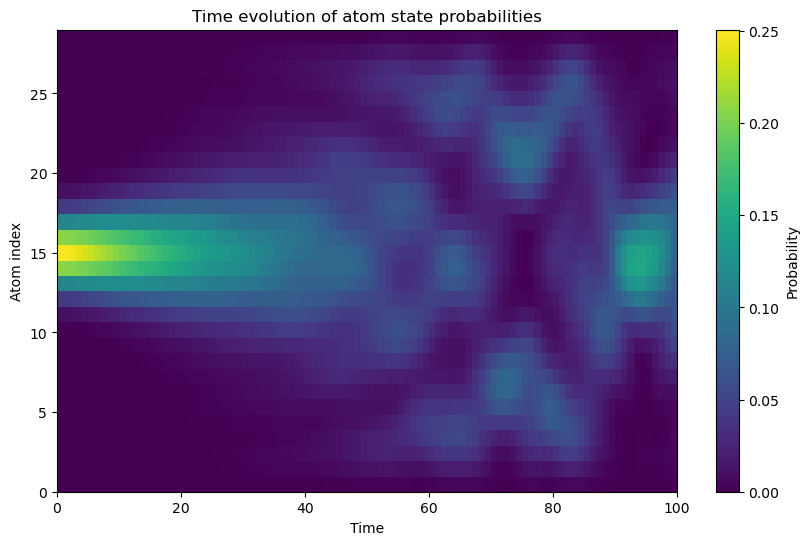

In [42]:
# Define the arguments for the Hamiltonian
tau = 0.1 * t_max
args = {'tau' = tau}

# Solve the time evolution
result = mesolve(H_eff, psi0, times, [], [], args=args)

# Extract and plot the results
populations = [expect(basis(N, i).proj(), result.states) for i in range(N)]

# Plot the time evolution of atom state probabilities as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(populations, aspect='auto', origin='lower', cmap='viridis', extent=[0, times[-1], 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()

In [29]:
y1, y2 = survival_probabilities(d_hats, times, distance=optimized_distance, Psi_0=psi0)
plt.figure(figsize=(10, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()
# Plot atoms with their dipole moments
positions = chain_positions(fixed_dist, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], d_hats[i][0] * 0.1, d_hats[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
plt.title('Atom Positions and optimal Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

# old implementation

In [5]:
V_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        V_matrix[i, j] = V_coefficients(positions[i], positions[j])

# Perform the Fourier transform
from scipy.fft import fft2, fftshift
V_fourier = fftshift(fft2(V_matrix))

from numpy.linalg import eig
# Compute the eigenvalues of the real-space matrix
V_eigenvalues_real, _ = eig(V_matrix)
V_eigenvalues_real = np.real(V_eigenvalues_real)

# Perform the Fourier transform
V_fourier = fftshift(fft2(V_matrix))

# Compute the eigenvalues of the Fourier-transformed matrix
V_eigenvalues_fourier, _ = eig(V_fourier)
V_eigenvalues_fourier = np.real(V_eigenvalues_fourier)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the real-space matrix V
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix V (Real Space)')
plt.imshow(V_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='V value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

# Plot the Fourier-space matrix V
plt.subplot(1, 2, 2)
plt.title('Fourier Transform of V Matrix')
plt.imshow(np.abs(V_fourier), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency index')
plt.ylabel('Frequency index')

plt.tight_layout()
plt.show()

# Plot the eigenvalues in real space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Real Space')
plt.plot(np.real(V_eigenvalues_real), np.imag(V_eigenvalues_real), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Plot the eigenvalues in Fourier space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Fourier Space')
plt.plot(np.real(V_eigenvalues_fourier), np.imag(V_eigenvalues_fourier), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

In [6]:
Gamma_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Gamma_matrix[i, j] = Gamma_coefficients(positions[i], positions[j])

# Perform the Fourier transform
Gamma_fourier = fftshift(fft2(Gamma_matrix))
# Compute the eigenvalues of the real-space matrix
Gamma_eigenvalues_real, _ = eig(Gamma_matrix)
Gamma_eigenvalues_real = np.real(Gamma_eigenvalues_real)
# Compute the eigenvalues of the Fourier-transformed matrix
Gamma_eigenvalues_fourier, _ = eig(Gamma_fourier)
Gamma_eigenvalues_fourier = np.real(Gamma_eigenvalues_fourier)

# Plot the results
plt.figure(figsize=(12, 6))
# Plot the real-space matrix Gamma
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix Gamma (Real Space)')
plt.imshow(Gamma_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Gamma value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

# Plot the Fourier-space matrix Gamma
plt.subplot(1, 2, 2)
plt.title('Fourier Transform of Gamma Matrix')
plt.imshow(np.abs(Gamma_fourier), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency index')
plt.ylabel('Frequency index')

plt.tight_layout()
plt.show()

# Plot the eigenvalues in real space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Real Space')
plt.plot(np.real(Gamma_eigenvalues_real), np.imag(Gamma_eigenvalues_real), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Plot the eigenvalues in Fourier space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Fourier Space')
plt.plot(np.real(Gamma_eigenvalues_fourier), np.imag(Gamma_eigenvalues_fourier), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

In [7]:
# Extract the diagonal elements of the Gamma matrix
Gamma_diagonal = np.zeros_like(Gamma_matrix)
for i in range(N):
    Gamma_diagonal [i, i] = Gamma_eigenvalues_real[i]
plt.figure(figsize=(12, 6))

# Plot the real-space matrix Gamma
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix Gamma (Real Space)')
plt.imshow(Gamma_diagonal, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Gamma value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

plt.tight_layout()
plt.show()

In [ ]:
#############################################---------        N x N case           ---------###########################################################

In [ ]:
H_red_list = reduced_H(H_list)
print('NxN H_eff:', H_red_list[0])

#Psi_01 = generic_superposition([basis(N, i) for i in range(N-1)])
Psi_01 = (basis(N,0)-basis(N,1)).unit() # only one atom is excited
print('Psi(0):', Psi_01)
norms = calculate_norms(x_vals, t_vals, H_red_list, Psi_01)

In [ ]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is N x N; for symmetric distance values')
#plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is N x N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_.mp4', writer='ffmpeg')
plt.show()

In [ ]:
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_230
# plot phi(distances)
H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in x_vals]
H_red_list = reduced_H(H_list)

# Calculate the phases for the off-diagonal elements
phases_12 = [np.angle(H[0, 1]) / np.pi for H in H_red_list]
phases_13 = [np.angle(H[0, 2]) / np.pi for H in H_red_list]
phases_23 = [np.angle(H[1, 2]) / np.pi for H in H_red_list]

# Plotting the phases   
plt.figure(figsize=(15, 5))
plt.plot(x_vals, phases_12, label=r'$H_{12}$')
plt.plot(x_vals, phases_13, label=r'$H_{31}$') #its the same as 12

plt.xlabel(r'Distance x / $\lambda_0$')
plt.ylabel(r'Phase / $\pi$')
plt.title('Phase of off-diagonal entries of H over distances')
plt.legend()
plt.savefig(save_path + 'phase_plot.svg')  
plt.show()

## It does matter whether or not I reduce the Hamiltonean!!

In [ ]:
#############################################---------      2^N x 2^N case         ----------##################################################

In [ ]:
#### x = lambda / 2 case:
x_special = 0.5
x_vals_ = np.concatenate((x_vals[[0, int(x_size/2), -1]], np.array([x_special])))

print(f'2^{N} x 2^{N} H_eff: ', H_list[0])

single_exc_basis = single_excitation_basis(N)
#Psi_0 = generic_superposition(single_exc_basis)
Psi_0 = (single_exc_basis[N-1] + single_exc_basis[N-2]).unit()  # only the first atom is excited
print('Psi(0):', Psi_0)

norms = calculate_norms(x_vals, t_vals, H_list, Psi_0)

In [ ]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is2^N x 2^N; for symmetric distance values')
#plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is 2^N x 2^N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_sq.mp4', writer='ffmpeg')
plt.show()

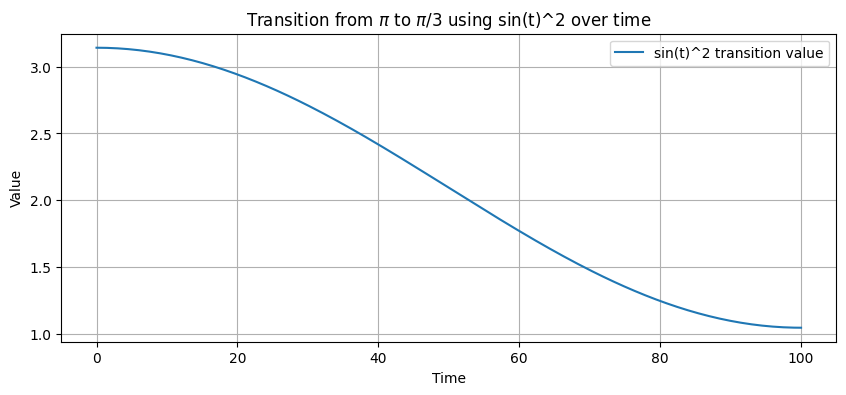

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def phi(t):
    """
    Returns a value that transitions from np.pi to np.pi/3 using a sin(t)^2 transition over the time interval [0, t_max].
    
    Parameters:
    - t: current time
    - t_max: maximum time
    
    Returns:
    - value: interpolated value between np.pi and np.pi/3
    """
    pi_start = np.pi
    pi_end = np.pi / 3
    
    # Normalize time to the range [0, pi]
    normalized_time = (t / t_max) * np.pi
    
    # Apply sin^2 transition
    sin_squared = np.sin(normalized_time / 2)**2
    
    return pi_start + (pi_end - pi_start) * sin_squared

# Example usage:
t_max = 100  # example maximum time
times = np.linspace(0, t_max, 200)

values = [phi(t) for t in times]

# Plot the function to visualize the transition
plt.figure(figsize=(10, 4))
plt.plot(times, values, label='sin(t)^2 transition value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Transition from $\pi$ to $\pi/3$ using sin(t)^2 over time')
plt.legend()
plt.grid(True)
plt.show()